# Group 18 Final Project Submission Strategy

## Libraries Import

Import relevant libraries

In [2]:
# import all libraries
import ta as ta
from ta.utils import dropna
from ta.trend import EMAIndicator, SMAIndicator
from ta.momentum import RSIIndicator
from ta.trend import SMAIndicator
from ta.volatility import AverageTrueRange

import math
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from matplotlib.lines import Line2D

import warnings
warnings.filterwarnings('ignore')

## PART 1: Stock Selection

### Find Most Actively Traded Sector
Sectors are determined based on the S&P Sectors (https://corporatefinanceinstitute.com/resources/valuation/the-sp-sectors/#:~:text=The%20order%20of%20the%2011,%2C%20Real%20Estate%2C%20and%20Materials.)  
Below highlights the sectors under consideration along with the respective ETF that tracks them:
1. Consumer Discretionary (XLY)
2. Consumer Staples (XLP)
3. Health Care (XLV)
4. Industrials (XLI)
5. Information Technology (XLK)
6. Materials (XLB)
7. Real Estate (XLRE)
8. Communication Services (XLC)
9. Utilities (XLU)
10. Financials (XLF)
11. Energy (XLE)

In [3]:
# Initiate start and end date
start = '2010-01-01'
end = '2017-01-01'

sector_etfs = {
    "XLY": "Consumer Discretionary",
    "XLP": "Consumer Staples",
    "XLV": "Health Care",
    "XLI": "Industrials",
    "XLK": "Information Technology",
    "XLB": "Materials",
    "XLRE": "Real Estate",
    "XLC": "Communication Services",
    "XLU": "Utilities",
    "XLF": "Financials",
    "XLE": "Energy"
}

In [4]:
sector_volumes = []
for sector_etf, sector in sector_etfs.items():
    current_data = yf.download(sector_etf, start, end)
    current_volume = current_data['Volume'].median()
    if not math.isnan(current_volume):
        sector_volumes.append((sector_etf, current_volume))

top_5_sectors = sorted(sector_volumes, key=lambda x: x[1].iloc[0], reverse=True)[:5]

final_sectors = [etf for etf, volume in top_5_sectors]

print("Top 5 Sectors Identified by Median Trading Volume from 2010 to 2016:")
for etf in final_sectors:
    print(sector_etfs[etf], "-", etf)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['XLC']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2017-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1262322000, endDate = 1483246800")')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 

Top 5 Sectors Identified by Median Trading Volume from 2010 to 2016:
Financials - XLF
Energy - XLE
Industrials - XLI
Utilities - XLU
Information Technology - XLK


Communication Services is removed from consideration as the ETF that tracks the sector index does not have a long enough history.

### Top 10 Holdings in Each ETF Sector
* Financials: https://finance.yahoo.com/quote/XLF/holdings/
* Energy: https://finance.yahoo.com/quote/XLE/holdings/
* Industrials: https://finance.yahoo.com/quote/XLI/holdings/
* Utilities: https://finance.yahoo.com/quote/XLU/holdings/
* Information Technology: https://finance.yahoo.com/quote/XLK/holdings/

In [5]:
financials = {
    "BRK-B": "Berkshire Hathaway Inc.",
    "JPM": "JPMorgan Chase & Co.",
    "V": "Visa Inc.",
    "MA": "Mastercard Incorporated",
    "BAC": "Bank of America Corporation",
    "WFC": "Wells Fargo & Company",
    "GS": "The Goldman Sachs Group, Inc.",
    "SPGI": "S&P Global Inc.",
    "AXP": "American Express Company",
    "MS": "Morgan Stanley"
}

energy = {
    "XOM": "Exxon Mobil Corporation",
    "CVX": "Chevron Corporation",
    "COP": "ConocoPhillips",
    "WMB": "The Williams Companies, Inc.",
    "EOG": "EOG Resources, Inc.",
    "SLB": "Schlumberger Limited",
    "OKE": "ONEOK, Inc.",
    "PSX": "Phillips 66",
    "MPC": "Marathon Petroleum Corporation",
    "KMI": "Kinder Morgan, Inc."
}

industrials = {
    "GE": "GE Aerospace",
    "CAT": "Caterpillar Inc.",
    "RTX": "RTX Corporation",
    "UBER": "Uber Technologies, Inc.",
    "UNP": "Union Pacific Corporation",
    "HON": "Honeywell International Inc.",
    "ETN": "Eaton Corporation plc",
    "ADP": "Automatic Data Processing, Inc.",
    "LMT": "Lockheed Martin Corporation",
    "BA": "The Boeing Company"
}

utilities = {
    "NEE": "NextEra Energy, Inc.",
    "SO": "The Southern Company",
    "DUK": "Duke Energy Corporation",
    "CEG": "Constellation Energy Corporation",
    "SRE": "Sempra",
    "AEP": "American Electric Power Company, Inc.",
    "D": "Dominion Energy, Inc.",
    "PEG": "Public Service Enterprise Group Incorporated",
    "PCG": "PG&E Corporation",
    "VST": "Vistra Corp."
}

info_technology = {
    "AAPL": "Apple Inc.",
    "NVDA": "NVIDIA Corporation",
    "MSFT": "Microsoft Corporation",
    "AVGO": "Broadcom Inc.",
    "CRM": "Salesforce, Inc.",
    "ORCL": "Oracle Corporation",
    "AMD": "Advanced Micro Devices, Inc.",
    "CSCO": "Cisco Systems, Inc.",
    "ACN": "Accenture plc",
    "ADBE": "Adobe Inc."
}

### Identify High Trading Volume Stocks within Each Sector
The purpose of this is to find the stocks with the highest trading volume since a higher volume often means better liquidity, allowing us to trade the stock easily and we can assume market orders can be executed almost instantly in our strategy.   

However, sector's median trading volume will likely be more than an individual stock's median trading volume. As such, we set a threshold of 3 to multiply with stock's median trading volume. After which, the comparison with sector's median trading volume is made. If a stock is **able** to have a higher median trading volume *(post threshold adjustment)* than the sector's median trading volume, the stock will be considered for further analysis.

---

In [6]:
sector_holdings = {
    'XLF': financials,
    'XLE': energy,
    'XLI': industrials,
    'XLU': utilities,
    'XLK': info_technology
}

stocks = []

for sector, holdings in sector_holdings.items():
    sector_data = yf.download(sector, start, end)
    sector_volume = sector_data['Volume'].median()
    for index, company in holdings.items():
        index_data = yf.download(index, start, end)
        index_volume = index_data['Volume'].median()
        if not math.isnan(index_volume.iloc[0]) and index_volume.iloc[0] * 3 > sector_volume.iloc[0]:
            stocks.append(index)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

UBER and CEG is removed from consideration as they do not have a long enough stock history.

### Volatility and Sector Analysis

Volatility is determined by the standard deviation of returns by the stock

---

In [7]:
volatility_list = []
industry_list = []
sector_list = []

for stock in stocks:
    current_data = yf.download(stock, start, end)
    current_data['Return'] = current_data['Adj Close'].pct_change()

    current_volatility = current_data['Return'].std()
    volatility_list.append(current_volatility)

    current_industry = yf.Ticker(stock).info['industryDisp']
    industry_list.append(current_industry)

    current_sector = yf.Ticker(stock).info['sector']
    sector_list.append(current_sector)

data = pd.DataFrame({
    'Ticker': stocks,
    'Volatility': volatility_list,
    'Industry': industry_list,
    'Sector': sector_list
})

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [8]:
data = data.sort_values(by=['Sector', 'Volatility'], ascending=False, ignore_index=True)
data

,Ticker,Volatility,Industry,Sector
0,NEE,0.010591,Utilities - Regulated Electric,Utilities
1,SO,0.008716,Utilities - Regulated Electric,Utilities
2,AMD,0.035785,Semiconductors,Technology
3,NVDA,0.024687,Semiconductors,Technology
4,CRM,0.023360,Software - Application,Technology
5,AVGO,0.022362,Semiconductors,Technology
6,ADBE,0.017784,Software - Infrastructure,Technology
7,AAPL,0.016507,Consumer Electronics,Technology
8,CSCO,0.016447,Communication Equipment,Technology
9,ORCL,0.015184,Software - Infrastructure,Technology


### Correlation Analysis

Choose stocks that are in a different sector and have less than 0.60 correlation coefficient to one another's returns. Stocks are chosen in order of volatility.

We chose stocks that are in different sector, and with returns that are less correlated with each other. For our trading strategy, this approach offers more stable returns and less overall risk, as different assets will likely react differently to economic shifts. By training our strategy on a range of price patterns, it could be more adaptable to diverse market conditions, enhancing its robustness over time.

In [9]:
correlation_df = pd.DataFrame()

for stock in data['Ticker'].tolist():
    current_data = yf.download(stock, start, end)
    correlation_df[stock] = current_data['Adj Close'].pct_change()

corr_matrix = correlation_df.corr()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [10]:
added_sectors = set()
selected_stocks = []

for index, row in data.iterrows():
    sector = row['Sector']

    # Check if the sector has been added before
    if sector not in added_sectors:
        stock = row['Ticker']
        if len(selected_stocks) == 0:
          added_sectors.add(sector)
          selected_stocks.append(stock)
        else:
          i = 0
          while i < len(selected_stocks):
            if corr_matrix[stock][selected_stocks[i]] < 0.60:
              i += 1
              if i == len(selected_stocks):
                added_sectors.add(sector)
                selected_stocks.append(stock)
              else:
                continue
            else:
              break
selected_stocks

['NEE', 'AMD', 'CAT', 'BAC', 'WMB']

### Selected stocks

Our selected stocks based on our choosing criteria are as follows

In [11]:
stocks = selected_stocks
stocks

['NEE', 'AMD', 'CAT', 'BAC', 'WMB']

## PART 2: Running the Strategy

### Common Class

Our common class is created to handle common functions such as:

- Plotting of close graphs of individual stocks selected to run strategy
- Handling buy and sell orders
- Calculating and storing balances/returns
- Calculating and plotting strategy performance results

In [26]:
class Common_Class():

  def __init__(self, symbols, start, end, interval, capital, transcation_cost, verbose = True):
    self.symbols = symbols
    self.start = start
    self.end = end
    self.interval = interval
    self.initial_capital = capital
    self.capital =  capital
    self.transaction_cost = transcation_cost
    self.quantity = {symbol: 0 for symbol in symbols} # quantities to buy/sell
    self.position = {symbol: 0 for symbol in symbols} # the trades in progress, long or short
    self.trades = 0
    self.verbose = verbose # if true, print detailed output (logs)
    self.stored_data = pd.DataFrame(columns=['trade', 'date', 'position', 'price', 'symbol', 'quantity', 'capital', 'vix']) # store trade details
    self.data = {}
    self.prepare_data() # prepares the data

  def prepare_data(self):
    vix = yf.download('^VIX', start=self.start, end=self.end, interval=self.interval)
    vix_price = vix.rename(columns={'Adj Close': 'VIX'})['VIX'].rename(columns={'^VIX': 'VIX'})
    for symbol in self.symbols:
      hist_stock = yf.download(symbol, start = self.start, end = self.end, interval = self.interval)
      bt_data = pd.DataFrame()
      bt_data["Adj_Close_Price"] = hist_stock["Adj Close"]
      bt_data["Log Return"] = np.log(bt_data["Adj_Close_Price"] / bt_data["Adj_Close_Price"].shift(1))
      bt_data["High"] = hist_stock["High"]
      bt_data["Low"] = hist_stock["Low"]
      bt_data = bt_data.merge(vix_price, left_index=True, right_index=True)
      bt_data = bt_data.dropna()
      self.data[symbol] = bt_data
    hist_benchmark = yf.download("SPY", start = self.start, end = self.end, interval = self.interval)
    self.data["SPY"] = pd.DataFrame()
    self.data["SPY"]["Close_Price"] = hist_benchmark["Adj Close"]
    self.data["SPY"]["Log Return"] = np.log(self.data["SPY"]["Close_Price"] / self.data["SPY"]["Close_Price"].shift(1))
    self.data["SPY"].index = self.data["SPY"].index.strftime('%Y-%m-%d')

  def close_graph(self):
    plt.figure(figsize=(15, 5))
    for symbol in self.symbols:
      plt.plot(self.data[symbol]["Adj_Close_Price"], label=symbol, linestyle='dashed')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.title("Close Prices of All Stocks")
    plt.legend()
    plt.grid()
    plt.show()

  def return_date_price(self, bar, symbol):
    # Get Price and Date
    date = str(self.data[symbol].index[bar])[:10]
    price = self.data[symbol].Adj_Close_Price.iloc[bar]
    return date, price

  def realised_balance(self, bar):
    # Get realised capital in account at a given time period / bar
    date, price = self.return_date_price(bar, self.symbols[0]) # Only concerned with date so any stock will do
    print("Date :{} | Realised Balance: {:0.1f}".format(date, self.capital))

  def unrealised_balance(self, bar):
    # Get unrealised capital (trades in progress) in account at a given time period / bar
    total_ub = 0
    for symbol in self.symbols: # Check for all trades in progress for each stock
      date, price = self.return_date_price(bar, symbol)
      total_ub += self.quantity[symbol] * price
    print("Date :{} | Unrealised Balance: {:0.1f}".format(date, total_ub))

  def total_balance(self, bar):
    # Unrealised plus realised capital
    tb = 0
    for symbol in self.symbols:
      date, price = self.return_date_price(bar, symbol)
      tb += self.quantity[symbol] * price
    tb += self.capital
    # print("Date :{} | Total Balance: {:0.1f}".format(date, tb))
    return tb

  def store_results(self, trade, date, position, price, symbol, quantity, capital, vix):
    trade_detail = pd.DataFrame({
      'trade': pd.Series(trade),
      'date': pd.Series(date),
      'position': pd.Series(position),
      'price': pd.Series(price),
      'symbol': pd.Series(symbol),
      'quantity': pd.Series(quantity),
      'capital': pd.Series(capital),
      'vix': pd.Series(vix) # Store current vix value
    })
    self.stored_data = pd.concat([self.stored_data, trade_detail])

  def performance_plots(self):

    capital_df = self.capital_df
    capital_df.index = pd.to_datetime(capital_df.index)
    interval = str(self.interval)
    vix_threshold = yf.download('^VIX', start=self.start, end=self.end, interval=self.interval)['Adj Close'].quantile(0.9).item()

   # Plot the equity curve for both strategies
    plt.figure(figsize=(15, 5))
    plt.plot(capital_df['capital_after_settlement'], label='Dynamic Strategy')
    plt.plot(capital_df['capital_equal_weighted'], label='Buy-and-Hold Strategy')
    plt.xlabel("Days")
    plt.ylabel("Capital")
    plt.title("Dynamic Strategy vs Buy-and-Hold Strategy Returns")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Drawdowns
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    # Plot drawdown for Buy-and-Hold strategy
    ax[0].plot(capital_df["Total_Stock_Returns_cum_sum"], label='Cumulative Returns')
    ax[0].plot(capital_df["Cum_Max_ews"], label='Maximum Returns')
    ax[0].set_xlabel("Date")
    ax[0].set_ylabel("Cumulative Returns")
    ax[0].set_title("Drawdown Buy-and-Hold Strategy")
    ax[0].legend()

    # Plot drawdown for dynamic strategy
    ax[1].plot(capital_df["capital_returns_log_cum_sum"], label='Cumulative Returns')
    ax[1].plot(capital_df["Cum_Max"], label='Maximum Returns')
    ax[1].set_xlabel("Date")
    ax[1].set_ylabel("Cumulative Returns")
    ax[1].set_title("Drawdown for Dynamic Strategy")
    ax[1].legend()

    # Plot histograms
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    # Plot the histogram for the buy-and-hold log returns in the first subplot
    ax[0].hist(capital_df['Total_Stock_Returns'], bins=30, color='blue', alpha=0.7)
    ax[0].set_title(f"Stock Log Returns for Buy-and-Hold Strategy")
    ax[0].set_xlabel('Log Returns')
    ax[0].set_ylabel('Frequency')
    ax[0].grid(True)

    # Plot the histogram for the strategy log returns in the second subplot
    ax[1].hist(capital_df['capital_log_returns'], bins=30, color='green', alpha=0.7)
    ax[1].set_title(f"Strategy Log Returns for Dynamic Strategy")
    ax[1].set_xlabel('Log Returns')
    ax[1].set_ylabel('Frequency')
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

    # Strategy vs Buy-and-Hold in different periods
    plt.figure(figsize=(15, 5))
    plt.plot(capital_df['Total_Stock_Returns_cum_sum'], color='orange', label='Buy-and-Hold Stock Returns', linestyle='dashed')
    plt.plot(capital_df['capital_returns_log_cum_sum'].dropna(), label ='Strategy Returns')
    plt.title("Strategy Vs Buy-and-Hold Cum Return Curve")
    plt.xlabel(interval)
    plt.fill_between(
      capital_df.index,
      y1=0,
      y2=2,
      where=(capital_df['VIX'] > vix_threshold),
      color='red',
      alpha=0.3
    )

    plt.fill_between(
      capital_df.index,
      y1=0,
      y2=2,
      where=(capital_df['VIX'] <= vix_threshold),
      color='green',
      alpha=0.3
    )
    legend_elements = [
      Line2D([0], [0], color='green', lw=4, alpha=0.3, label=f'VIX ≤ Threshold'),
      Line2D([0], [0], color='red', lw=4, alpha=0.3, label=f'VIX > Threshold')
    ]
    plt.legend(handles=legend_elements + plt.gca().get_legend_handles_labels()[0], loc='upper right')
    plt.show()

  def performance(self):

    df = pd.DataFrame()
    df['capital'] = self.stored_data.groupby('date')['capital'].mean()
    df['VIX'] = self.stored_data.groupby('date')['vix'].mean()

    trade_start_date = df['capital'].index[0]
    trade_end_date = df['capital'].index[-1]

    for symbol in self.symbols:
      current_stock_returns = (self.data[symbol][trade_start_date: trade_end_date]['Log Return'].tolist())
      df[f'Log_Returns_{symbol}'] = current_stock_returns

    curr_columns = df.columns
    df['Total_Stock_Returns'] = (df.loc[:, curr_columns[-len(self.symbols):]].sum(1))/len(self.symbols) # Equal Weighted Stock Returns
    df['Total_Stock_Returns_cum_sum'] = df['Total_Stock_Returns'].cumsum()
    df['capital_equal_weighted'] = self.initial_capital * np.exp(df['Total_Stock_Returns_cum_sum'])

    df['capital_after_settlement'] = df['capital'].shift(-1)
    df['capital_regular_returns'] = (df['capital_after_settlement']/df['capital'] - 1)
    df['capital_log_returns'] = np.log(df['capital_after_settlement']/df['capital'])
    df['capital_returns_log_cum_sum'] = df['capital_log_returns'].cumsum()

    df = df.dropna()
    capital_df = df

    print("="  * 50)
    print("Performance Metrics")

    # dictionary to store metrics
    metrics = {}

     # Assume risk free rate to be 0
    risk_free_rate = 0

    # Remove NaN values
    merged_data = pd.DataFrame({
        'equal_weighted_returns': capital_df['Total_Stock_Returns'],
        'strategy_returns': capital_df['capital_log_returns'],
        'benchmark_returns': self.data["SPY"]['Log Return']
    }).dropna()

    # Annual returns
    annual_ret = merged_data[['equal_weighted_returns', 'strategy_returns', 'benchmark_returns']].mean() * 252
    annual_regular_ret = np.exp(annual_ret)-1
    metrics['Annual Returns'] = [annual_regular_ret[0], annual_regular_ret[1]]

    # Annual Standard deviation
    annual_regular_std = (np.exp(merged_data[['equal_weighted_returns', 'strategy_returns', 'benchmark_returns']])-1).std() * (252 **0.5)
    metrics['Annual Std Dev'] = [annual_regular_std[0], annual_regular_std[1]]

    # Sharpe Ratio
    sr = annual_regular_ret/ annual_regular_std
    metrics['Sharpe Ratio'] = [sr[0], sr[1]]

    # Beta
    matrix_strat = merged_data[['strategy_returns', 'benchmark_returns']].cov()
    Beta_strat = matrix_strat.iat[0,1] / matrix_strat.iat[1,1]
    matrix_ews = merged_data[['equal_weighted_returns', 'benchmark_returns']].cov()
    Beta_ews = matrix_ews.iat[0,1] / matrix_ews.iat[1,1]
    metrics['Beta'] = [Beta_ews, Beta_strat]

    # Alpha
    alpha_strat = annual_regular_ret[1] - risk_free_rate - Beta_strat * (annual_regular_ret[2] - risk_free_rate)
    alpha_ews = annual_regular_ret[0] - risk_free_rate - Beta_ews * (annual_regular_ret[2] - risk_free_rate)
    metrics['Alpha'] = [alpha_ews, alpha_strat]

    # Returns on investment in percent
    Total_Log_ret_ews = capital_df['Total_Stock_Returns'].sum()
    Regular_ROI_ews = (np.exp(Total_Log_ret_ews) - 1)
    Total_Log_ret_strat = capital_df['capital_log_returns'].sum()
    Regular_ROI_strat = (np.exp(Total_Log_ret_strat) - 1)
    metrics['Returns on Investment'] = [Regular_ROI_ews, Regular_ROI_strat]

    # Max Drawdown
    capital_df["Cum_Max_ews"] = capital_df["Total_Stock_Returns_cum_sum"].cummax()
    capital_df["drawdown_ews"] = capital_df["Cum_Max_ews"] - capital_df["Total_Stock_Returns_cum_sum"]
    max_drawdown_ews = capital_df["drawdown_ews"].max()
    capital_df["Cum_Max"] = capital_df["capital_returns_log_cum_sum"].cummax()
    capital_df["drawdown"] = capital_df["Cum_Max"] - capital_df["capital_returns_log_cum_sum"]
    max_drawdown_strat = capital_df['drawdown'].max()
    metrics['Max Drawdown'] = [max_drawdown_ews, max_drawdown_strat]

    # Calmar Ratio
    calmar_ratio_ews = (annual_regular_ret[0]) / max_drawdown_ews
    calmar_ratio_strat = (annual_regular_ret[1]) / max_drawdown_strat
    metrics['Calmar Ratio'] = [calmar_ratio_ews, calmar_ratio_strat]

    # Calculate Sortino Ratio
    converted_returns_ews = (np.exp(merged_data['equal_weighted_returns'])-1).apply(lambda x: 0 if x > 0 else x)
    squared_converted_returns_ews = converted_returns_ews ** 2
    squared_sum_converted_returns_ews = np.sum(squared_converted_returns_ews)
    downside_deviation_ews = np.sqrt(squared_sum_converted_returns_ews / len(converted_returns_ews))
    annual_converted_sd_ews = downside_deviation_ews * np.sqrt(252)
    sortino_ratio_ews = (annual_regular_ret[0]) / annual_converted_sd_ews

    converted_returns_strat = (np.exp(merged_data['strategy_returns'])-1).apply(lambda x: 0 if x > 0 else x)
    squared_converted_returns_strat = converted_returns_strat ** 2
    squared_sum_converted_returns_strat = np.sum(squared_converted_returns_strat)
    downside_deviation_strat = np.sqrt(squared_sum_converted_returns_strat / len(converted_returns_strat))
    annual_converted_sd_strat = downside_deviation_strat * np.sqrt(252)
    sortino_ratio_strat = (annual_regular_ret[1]) / annual_converted_sd_strat
    metrics['Sortino Ratio'] = [sortino_ratio_ews, sortino_ratio_strat]

    # Tracking Error
    tracking_error_strat = np.std(merged_data['strategy_returns'] - merged_data['benchmark_returns']) * np.sqrt(252)
    tracking_error_ews = np.std(merged_data['equal_weighted_returns'] - merged_data['benchmark_returns']) * np.sqrt(252)

    # Information Ratio
    information_ratio_strat = (annual_regular_ret[1] - annual_regular_ret[2]) / tracking_error_strat
    information_ratio_stock = (annual_regular_ret[0] - annual_regular_ret[2]) / tracking_error_ews
    metrics['Information Ratio'] = [information_ratio_stock, information_ratio_strat]

    # Treynor_ratio
    Treynor_ratio_strat = annual_regular_ret[1] / Beta_strat
    Treynor_ratio_ews = annual_regular_ret[0] / Beta_ews
    metrics['Treynor Ratio'] = [Treynor_ratio_ews, Treynor_ratio_strat]

    performance_df = pd.DataFrame(metrics, index=["Buy-and-Hold Strategy", "Dynamic Strategy"])
    display(performance_df)

    self.capital_df = capital_df

    #Total Trades
    print("Total Trades by strategy: {}".format(self.trades))

    print("=" * 50)

  def buy_order(self, bar, symbol, quantity=None, dollar=None):
    date, price = self.return_date_price(bar, symbol)
    if quantity == None:
      quantity = int(dollar/price)
      if quantity == 0:
        return
    self.capital = self.capital - ((quantity * price) * (1 + self.transaction_cost)) # Update capital
    self.quantity[symbol] = self.quantity[symbol] + quantity
    self.trades = self.trades + 1
    self.position[symbol] = 1
    tb = self.total_balance(bar)
    vix = self.data[symbol].iloc[bar]['VIX']
    self.store_results(self.trades, date, self.position[symbol], price, symbol, quantity, tb, vix)

    if self.verbose:
      print("Bought {} shares of {} at {:0.1f} per share worth ${:0.1f}".format(quantity, symbol, price, quantity * price))
      self.realised_balance(bar)
      # self.unrealised_balance(bar)
      # self.total_balance(bar)

  def sell_order(self, bar, symbol, quantity=None, dollar=None):
    date, price = self.return_date_price(bar, symbol)
    if quantity == None:
      quantity = int(dollar/price)
      if quantity == 0:
        return
    self.capital = self.capital + ((quantity * price) * (1 - self.transaction_cost)) # Update Capital
    self.quantity[symbol] = self.quantity[symbol] - quantity
    self.trades = self.trades + 1
    self.position[symbol] = -1
    tb = self.total_balance(bar)
    vix = self.data[symbol].iloc[bar]['VIX']
    self.store_results(self.trades, date, self.position[symbol], price, symbol, quantity, tb, vix)

    if self.verbose:
      print("Sold {} shares of {} at {:0.1f} per share worth ${:0.1f}".format(quantity, symbol, price, quantity * price))
      self.realised_balance(bar)

  def last_trade(self, bar):
    for symbol in self.symbols:
      date, price = self.return_date_price(bar, symbol)
      last_quantity = self.quantity[symbol]
      self.capital = self.capital + last_quantity * price
      self.quantity[symbol] = 0 # no more quantity now; all will be settled
      self.trades = self.trades +1
      if self.position[symbol] == -1: # if closing out a short position
        last_quantity = -last_quantity # to keep a positive number in records.
        self.position[symbol] = 1 # to record we are buying to close out
      else:
        last_quantity = last_quantity # to keep a positive number in records
        self.position[symbol] = -1 # to record we are selling to close out

      tb = self.total_balance(bar)
      vix = self.data[symbol].iloc[bar]['VIX']
      self.store_results(self.trades, date, self.position[symbol], price, symbol, last_quantity, tb, vix)

    if self.verbose:
      print("Closed open trades for {} shares of {} at {:0.1f} per share worth ${:0.1f}".format(last_quantity, symbol, price, last_quantity * price))



### Strategy Class

Our strategy class inherits from the Common class. On top of functions from common class, our strategy class generates indicators for our strategy and handles the running of the strategy itself with support functions.

### Strategy Description

Our strategy has 2 components, a variation for volatile periods and another for non-volatile periods. Volatility of a period is determined by the VIX index. A VIX index value higher than the threshold we set will signify that the market is in a volatile period.


Our strategy makes use of the following indicators:

- RSI
- ATR
- SMA
- EMA
- VIX Index

---

During non-volatile periods, the strategy operates on the assummption that price movement will be minimal and less frequent. The focus is on long-term trends, using the SMA indicator with longer rolling periods to filter out noise and capture steady trends. When STMA > LTMA, it indicates upward momentum, triggering a long position. When STMA < LTMA, it indicates a potential down trend, triggering a short position. Additionally, a cooldown period of 6 bars is implemented to prevent immediate re-entry, minimising the overtrading during stable periods.

---

During volatile periods, the strategy shifts to a short-term focus as price movements are expected to be frequent and more pronounced. EMA and RSI indicators are used to capture time the peaks and the troughs, and enter for a short period of time to try and capture the price movement change.

---

For both volatile and non-volatile strategies, we manage our risk by having a stop loss level during the entry of each trade. We determine the stop loss levels using the ATR idicator, stop loss price being calculated by

stop loss price = entry price +- (ATR * multiplier)

The multiplier is higher during non volatile periods since we can afford to take slightly more risks, and is lower during volatile periods to ensure we exit positions early given volatile conditions.

At the end, we run an optimizer to determine the best RSI window, ATR window, STMA and LTMA windows for the strategy.



In [27]:
class Strategy(Common_Class):

  def go_long(self, bar, symbol, quantity = None, dollar = None): # either previously in position or fresh position
    if self.position[symbol] == -1:
      self.buy_order(bar, symbol, quantity = -self.quantity[symbol]) # to clear previous short position and therefore negative quantity.(already in position, thats why negative)
      self.position[symbol] = 0
    if quantity:
      self.buy_order(bar, symbol, quantity = quantity) # to create new order
    elif dollar:
      if dollar == 'all':
        dollar = self.capital
      self.buy_order(bar, symbol, dollar = dollar)

  def go_short(self, bar, symbol, quantity = None, dollar = None):
    if self.position[symbol] == 1:
      self.sell_order(bar, symbol, quantity = self.quantity[symbol]) # to clear previous long position
      self.position[symbol] = 0
    if quantity:
      self.sell_order (bar, symbol, quantity = quantity) # to create new order
    elif dollar:
      if dollar == 'all':
        dollar = self.capital
      self.sell_order(bar, symbol, dollar = dollar)

  def exit_trade(self, bar, symbol):
    if self.position[symbol] == 1:
      self.sell_order(bar, symbol, quantity = self.quantity[symbol])
      self.position[symbol] = 0

    if self.position[symbol] == -1:
      self.buy_order(bar, symbol, quantity = -self.quantity[symbol])
      self.position[symbol] = 0

  def reset(self):
    self.capital = self.initial_capital
    self.quantity = {symbol: 0 for symbol in self.symbols} # quantities to buy/sell
    self.position = {symbol: 0 for symbol in self.symbols} # the trades in progress, long or short
    self.trades = 0
    self.stored_data = pd.DataFrame(columns=['trade', 'date', 'position', 'price', 'symbol', 'quantity', 'capital', 'vix']) # store trade details

  def optimize_parameters(self):
    best_returns = None
    best_rsi_rolling_window, best_atr_window, best_stma_window, best_ltma_window = 0, 0, 0, 0
    rsi_rolling_windows = [10, 15, 20]
    atr_windows = [5, 10, 15]
    stma_ltma_windows = [(25, 50), (50, 100)]

    for rsi_rolling_window in rsi_rolling_windows:
      for atr_window in atr_windows:
        for stma_window, ltma_window in stma_ltma_windows:
          self.reset()
          returns = self.run_strategy(rsi_rolling_window, atr_window, stma_window, ltma_window, 5, 10)
          if best_returns == None or returns > best_returns:
            best_rsi_rolling_window, best_atr_window, best_stma_window, best_ltma_window = rsi_rolling_window, atr_window, stma_window, ltma_window
            best_returns = returns
    self.reset()

    print("="*25, "Optimized Parameters", "="*25)
    print("Best RSI rolling window:", best_rsi_rolling_window)
    print("Best ATR window:", best_atr_window)
    print("Best STMA window:", best_stma_window)
    print("Best LTMA window:", best_ltma_window)
    print("="*50)
    return best_rsi_rolling_window, best_atr_window, best_stma_window, best_ltma_window

  def calculate_RSI5(self, symbol):
    rsi_indicator = RSIIndicator(close = self.data[symbol]['Adj_Close_Price'], window=5, fillna=False)
    self.data[symbol]['RSI5'] = rsi_indicator.rsi()

  def calculate_ATR(self, symbol, atr_window):
    atr_indicator = AverageTrueRange(high=self.data[symbol]['High'], low=self.data[symbol]['Low'], close=self.data[symbol]['Adj_Close_Price'], window=atr_window)
    self.data[symbol]['ATR'] = atr_indicator.average_true_range()

  def calculate_SMA(self, symbol, sma_lr_window, sma_sr_window):
    STMA = SMAIndicator(close=self.data[symbol]["Adj_Close_Price"], window=sma_sr_window, fillna=True).sma_indicator()
    self.data[symbol]["STMA"] = STMA

    LTMA = SMAIndicator(close=self.data[symbol]["Adj_Close_Price"], window=sma_lr_window, fillna=True).sma_indicator()
    self.data[symbol]["LTMA"] = LTMA

  def calculate_EMA(self, symbol, ema_sr_window, ema_lr_window):
    STMA = EMAIndicator(close=self.data[symbol]['Adj_Close_Price'], window=ema_sr_window).ema_indicator()
    self.data[symbol][f'EMA{ema_sr_window}'] = STMA

    LTMA = EMAIndicator(close=self.data[symbol]['Adj_Close_Price'], window=ema_lr_window).ema_indicator()
    self.data[symbol][f'EMA{ema_lr_window}'] = LTMA

    self.data[symbol]['EMA_diff'] = self.data[symbol][f'EMA{ema_sr_window}'] - self.data[symbol][f'EMA{ema_lr_window}']
    self.data[symbol]['Weighted_EMA_diff'] = self.data[symbol]['EMA_diff'].ewm(span=5, adjust=False).mean()

  def run_stop_loss(self, bar, symbol, price, volatile=True):
    if self.position[symbol] == -1:
      # Check Stop Loss
      if price > self.stop_loss_price and volatile: # if triggered, immedietely enter position in opposite direction
        self.go_long(bar, symbol, dollar = self.capital/len(self.symbols))
        self.entry_price[symbol] = price
        self.stop_loss_price = price - (1 * self.data[symbol].iloc[bar]['ATR'])
        self.buy_cooldown[symbol] = 3
        self.stop_loss[symbol] = True
      elif price > self.stop_loss_price and not volatile: # if triggered, immedietely enter position in opposite direction
        self.go_long(bar, symbol, dollar = self.capital/len(self.symbols))
        self.entry_price[symbol] = price
        self.stop_loss_price = price - (1.5 * self.data[symbol].iloc[bar]['ATR'])
        self.buy_cooldown[symbol] = 10
        self.stop_loss[symbol] = True
    if self.position[symbol] == 1:
      # Check Stop Loss
      if price < self.stop_loss_price and volatile: # if triggered, immedietely enter position in opposite direction
        self.go_short(bar, symbol, dollar = self.capital/len(self.symbols))
        self.entry_price[symbol] = price
        self.stop_loss_price = price + (1 * self.data[symbol].iloc[bar]['ATR'])
        self.sell_cooldown[symbol] = 3
        self.stop_loss[symbol] = True
      elif price < self.stop_loss_price and not volatile: # if triggered, immedietely enter position in opposite direction
        self.go_short(bar, symbol, dollar = self.capital/len(self.symbols))
        self.entry_price[symbol] = price
        self.stop_loss_price = price + (1.5 * self.data[symbol].iloc[bar]['ATR'])
        self.sell_cooldown[symbol] = 10
        self.stop_loss[symbol] = True

  def run_nonvolatile_strategy(self, bar, symbol):
    date, price = self.return_date_price(bar, symbol)
    # If in trade, check for stop-loss conditions
    if self.entry_price[symbol] > 0:
      self.run_stop_loss(bar, symbol, price, False)

    long_term_buy_condition = self.data[symbol].iloc[bar]["STMA"] > self.data[symbol].iloc[bar]["LTMA"]
    long_term_sell_condition = self.data[symbol].iloc[bar]["STMA"] < self.data[symbol].iloc[bar]["LTMA"]
    if self.position[symbol] in [0, -1] and self.stop_loss[symbol] == False and self.sell_cooldown[symbol] == 0 and self.buy_cooldown[symbol] == 0:
      if long_term_buy_condition:
        self.go_long(bar, symbol, dollar = self.capital/len(self.symbols))
        self.entry_price[symbol] = price
        self.stop_loss_price = price - (1.5 * self.data[symbol].iloc[bar]['ATR'])
        self.buy_cooldown[symbol] = 10
        return
    elif self.position[symbol] in [0, 1] and self.stop_loss[symbol] == False and self.sell_cooldown[symbol] == 0 and self.buy_cooldown[symbol] == 0:
      if long_term_sell_condition:
        self.go_short(bar, symbol, dollar = self.capital/len(self.symbols))
        self.entry_price[symbol] = price
        self.stop_loss_price = price + (1.5 * self.data[symbol].iloc[bar]['ATR'])
        self.sell_cooldown[symbol] = 10
        return
    self.stop_loss[symbol] = False # Reset stop_loss
    # Update cooldown of stock
    if self.position[symbol] == 1:
      self.buy_cooldown[symbol] -= 1
    elif self.position[symbol] == -1:
      self.sell_cooldown[symbol] -= 1

    store_quantity = abs(self.quantity[symbol])
    tb = self.total_balance(bar)
    vix = self.data[symbol].iloc[bar]['VIX']
    self.store_results(0, date, self.position[symbol], price, symbol, store_quantity, tb, vix)

  def run_volatile_strategy(self, bar, symbol, rsi_rolling_window):
    date, price = self.return_date_price(bar, symbol)
    if self.entry_price[symbol] > 0:
      self.run_stop_loss(bar, symbol, price, True)

    rsi_upper = self.data[symbol]['RSI5'].rolling(window=rsi_rolling_window).quantile(0.75).iloc[bar] # find upper quantile of RSI5 from past 20 days
    rsi_lower = self.data[symbol]['RSI5'].rolling(window=rsi_rolling_window).quantile(0.25).iloc[bar] # find lower quantile of RSI5 from past 20 days
    sell_condition = (self.data[symbol].iloc[bar]['Weighted_EMA_diff'] < self.data[symbol].iloc[bar-1]['Weighted_EMA_diff']) and (self.data[symbol].iloc[bar]['RSI5'] > rsi_upper)
    buy_condition = (self.data[symbol].iloc[bar]['Weighted_EMA_diff'] < self.data[symbol].iloc[bar-1]['Weighted_EMA_diff']) and (self.data[symbol].iloc[bar]['RSI5'] < rsi_lower)

    if self.position[symbol] == -1: # time the trough
      if buy_condition:
        self.go_long(bar, symbol, dollar = self.capital/len(self.symbols))
        self.entry_price[symbol] = price
        self.stop_loss_price = price - (1 * self.data[symbol].iloc[bar]['ATR'])
        self.buy_cooldown[symbol] = 3
        self.position[symbol] = 1
        return
    elif self.position[symbol] == 1: # time the peak
      if sell_condition:
        self.go_short(bar, symbol, dollar = self.capital/len(self.symbols))
        self.entry_price[symbol] = price
        self.stop_loss_price = price + (1 * self.data[symbol].iloc[bar]['ATR'])
        self.sell_cooldown[symbol] = 3
        self.position[symbol] = -1
        return

    self.stop_loss[symbol] = False # Reset stop_loss
    # Update cooldown of stock
    if self.position[symbol] == 1:
      self.buy_cooldown[symbol] -= 1
    elif self.position[symbol] == -1:
      self.sell_cooldown[symbol] -= 1

    store_quantity = abs(self.quantity[symbol])
    tb = self.total_balance(bar)
    vix = self.data[symbol].iloc[bar]['VIX']
    self.store_results(0, date, self.position[symbol], price, symbol, store_quantity, tb, vix)

  def run_strategy(self, rsi_rolling_window, atr_window, sma_sr_window, sma_lr_window, ema_sr_window, ema_lr_window):
    self.stop_trading = False
    self.entry_price = {symbol: 0 for symbol in self.symbols}
    self.stop_loss_price = {symbol: 0 for symbol in self.symbols}
    self.buy_cooldown = {symbol: 0 for symbol in self.symbols}
    self.sell_cooldown = {symbol: 0 for symbol in self.symbols}
    self.stop_loss = {symbol: False for symbol in self.symbols}

    # Determine technical indicators
    for symbol in self.symbols:
      self.calculate_RSI5(symbol)
      self.calculate_ATR(symbol, atr_window)
      self.calculate_SMA(symbol, sma_sr_window, sma_lr_window)
      self.calculate_EMA(symbol, ema_sr_window, ema_lr_window)

    initial_bar = max(atr_window, sma_lr_window, ema_lr_window)
    vix_threshold = yf.download('^VIX', start=self.start, end=self.end, interval=self.interval)['Adj Close'] # Threshold for determining investor's confidence
    for bar in range(initial_bar, len(self.data[self.symbols[0]])): # from the available data bar to the last data bar
      vix_rolling_window = self.data[self.symbols[0]].iloc[bar-75:bar]['VIX']
      vix_threshold = vix_rolling_window.quantile(0.75).item()

      # Stop trading if balance goes below 0
      tb = self.total_balance(bar)
      if tb < 0:
        print("Capital ran out.")
        self.last_trade(bar)
        self.stop_trading = True
        break

      current_vix = self.data[self.symbols[0]].iloc[bar]['VIX']
      for stock in self.symbols:
        if current_vix > vix_threshold:
          self.run_volatile_strategy(bar, stock, rsi_rolling_window)
        else:
          self.run_nonvolatile_strategy(bar, stock)

    # Prevent last_trade func to run 2 times when early exit due to negative capital
    if self.stop_trading == False:
      self.last_trade(bar)

    return self.stored_data.iloc[-1]['capital']

  def print_stored_data(self):
    print(self.stored_data)


### Run Training

We first train the strategy from 2010 to 2016 to obtain the best parameters for that period using our optimizer.  

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Training Period



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


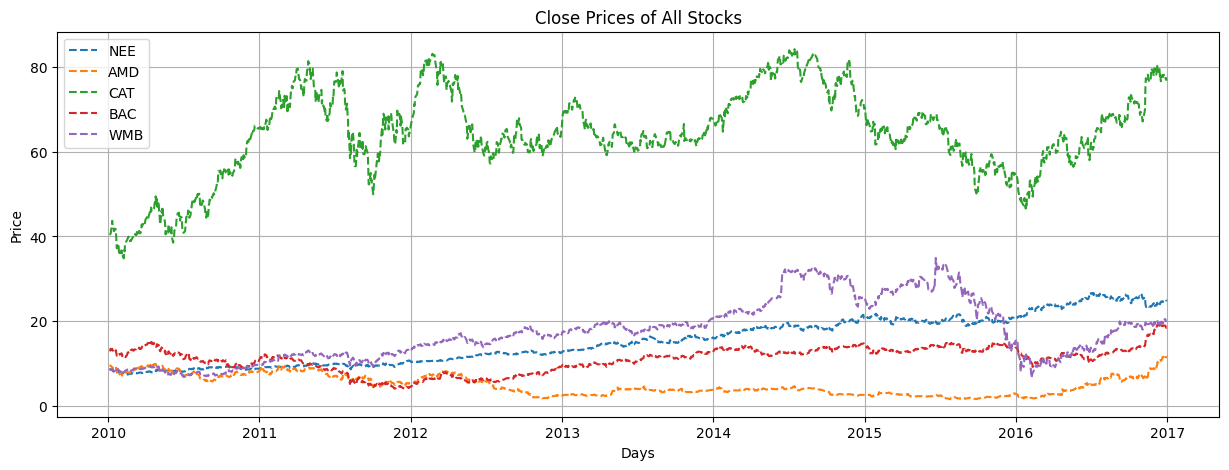

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

========================= Optimized Parameters =========================
Best RSI rolling window: 20
Best ATR window: 15
Best STMA window: 25
Best LTMA window: 50


Performance Metrics


,Annual Returns,Annual Std Dev,Sharpe Ratio,Beta,Alpha,Returns on Investment,Max Drawdown,Calmar Ratio,Sortino Ratio,Information Ratio,Treynor Ratio
Buy-and-Hold Strategy,0.094122,0.251128,0.374797,1.343755,-0.072531,0.841149,0.597539,0.157516,0.527957,-0.197032,0.070044
Dynamic Strategy,0.190729,0.195125,0.977470,-0.013063,0.192349,2.269219,0.306728,0.621817,1.556186,0.268079,-14.600263


[*********************100%***********************]  1 of 1 completed

Total Trades by strategy: 254


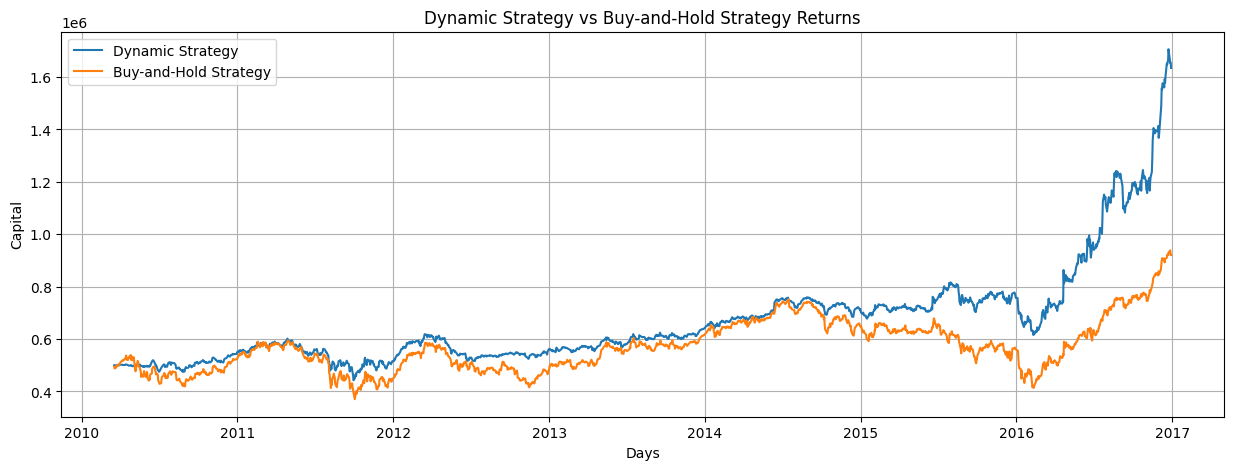

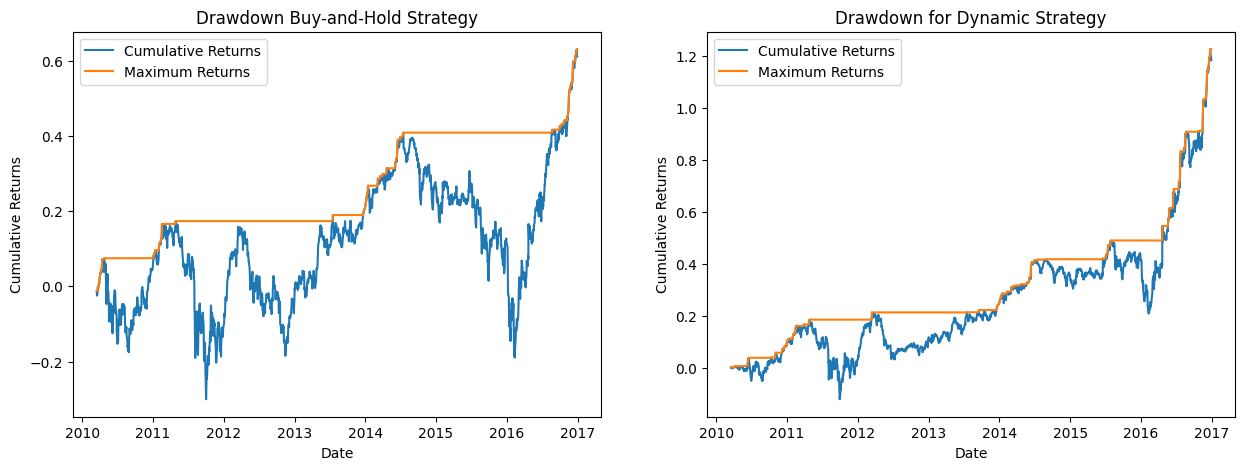

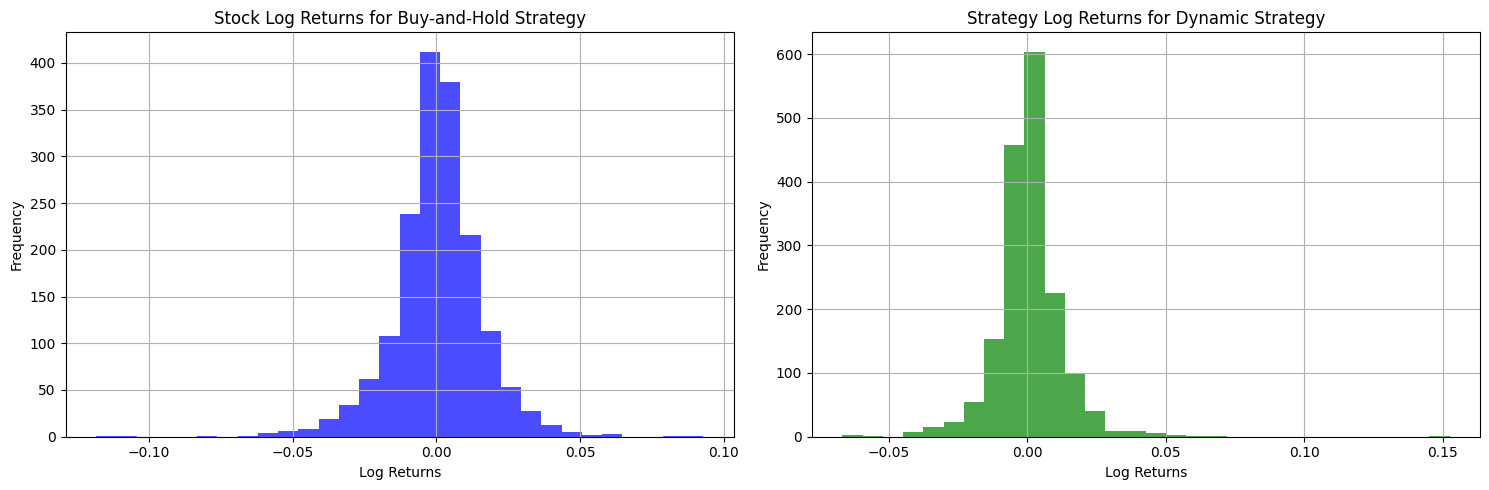

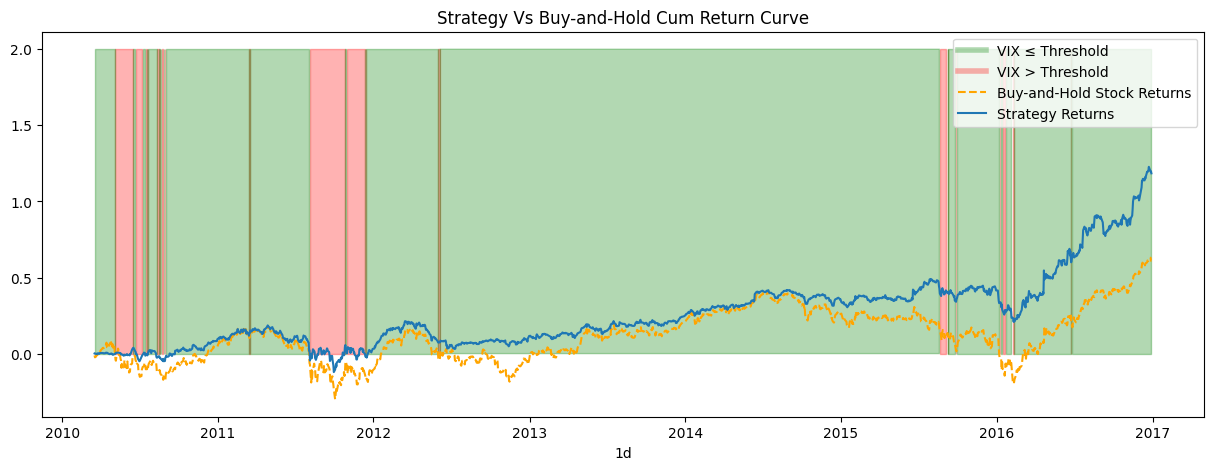

   trade        date position      price symbol quantity       capital  \
0      1  2010-03-18        1   7.890537    NEE    12673  5.000000e+05   
0      0  2010-03-18        0   9.390000    AMD        0  5.000000e+05   
0      0  2010-03-18        0  40.992767    CAT        0  5.000000e+05   
0      0  2010-03-18        0  13.637773    BAC        0  5.000000e+05   
0      0  2010-03-18        0   8.822261    WMB        0  5.000000e+05   
..   ...         ...      ...        ...    ...      ...           ...   
0    250  2016-12-30       -1  24.720762    NEE     2803  1.634610e+06   
0    251  2016-12-30       -1  11.340000    AMD    85929  1.634610e+06   
0    252  2016-12-30       -1  76.729813    CAT      798  1.634610e+06   
0    253  2016-12-30       -1  18.548580    BAC    10072  1.634610e+06   
0    254  2016-12-30       -1  20.091320    WMB     8008  1.634610e+06   

          vix  
0   16.620001  
0   16.620001  
0   16.620001  
0   16.620001  
0   16.620001  
..        ...  

In [28]:
if __name__ == "__main__":
  print('==' * 50)
  print('Training Period')
  A = Strategy(stocks, "2010-01-01", "2017-01-01", "1d", 500000, 0.0, False)
  A.close_graph()
  # Training
  best_rsi_rolling_window, best_atr_window, best_stma_window, best_ltma_window = A.optimize_parameters()
  #Training results
  A.run_strategy(best_rsi_rolling_window, best_atr_window, best_stma_window, best_ltma_window, 5, 10)
  A.performance()
  A.performance_plots()
  A.print_stored_data()


### Run Testing

We use the optimized parameters for testing from 2017 to 2019

[*********************100%***********************]  1 of 1 completed

Testing Period



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


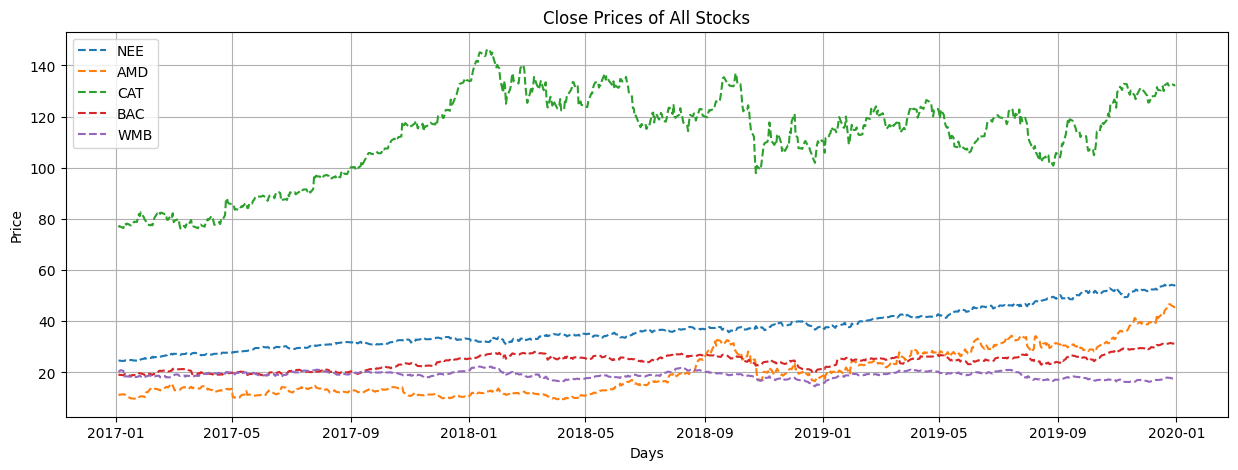

[*********************100%***********************]  1 of 1 completed


Performance Metrics


,Annual Returns,Annual Std Dev,Sharpe Ratio,Beta,Alpha,Returns on Investment,Max Drawdown,Calmar Ratio,Sortino Ratio,Information Ratio,Treynor Ratio
Buy-and-Hold Strategy,0.217871,0.193889,1.123689,1.158691,0.060752,0.731652,0.304676,0.715089,1.586130,0.676377,0.188032
Dynamic Strategy,0.200024,0.167036,1.197487,0.023820,0.196794,0.661883,0.261074,0.766158,1.745106,0.305640,8.397305


[*********************100%***********************]  1 of 1 completed

Total Trades by strategy: 70


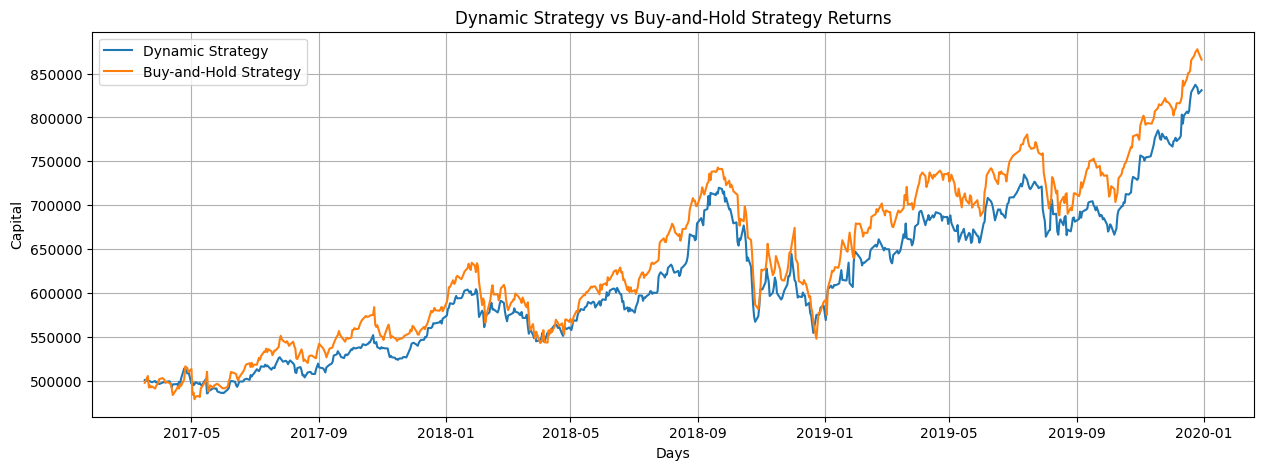

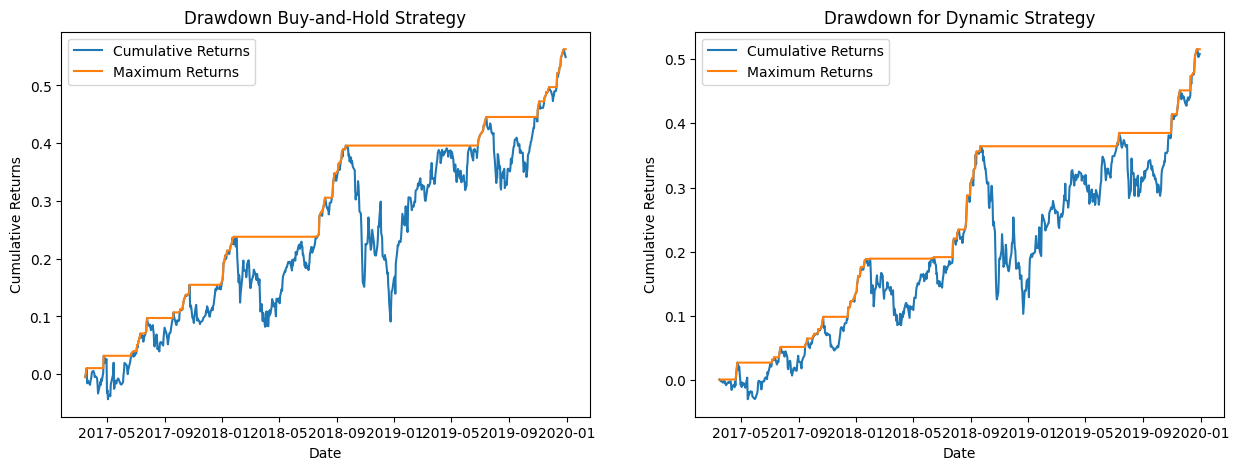

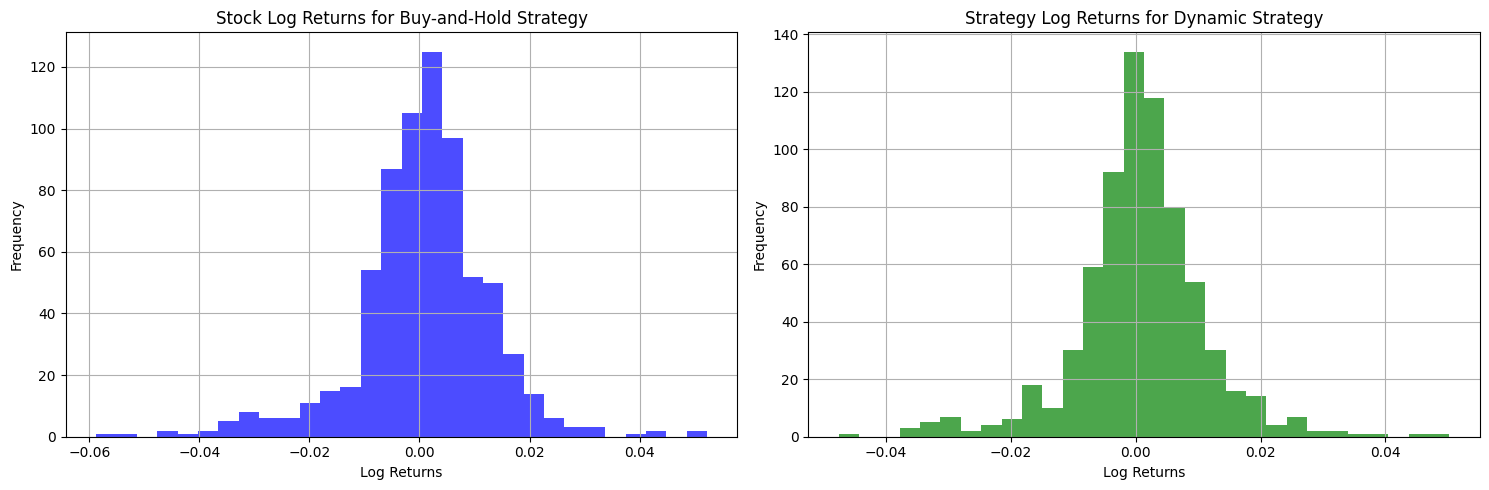

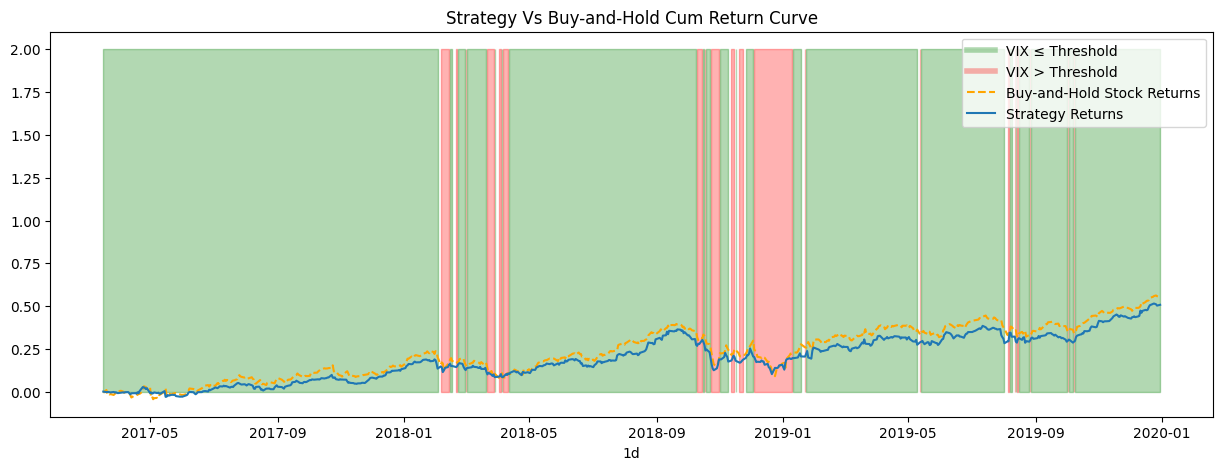

In [29]:
if __name__ == "__main__":

  #Testing results
  print('==' * 50)
  print('Testing Period')
  B = Strategy(stocks, "2017-01-01", "2020-01-01", "1d", 500000, 0.0, False)
  B.close_graph()
  B.run_strategy(best_rsi_rolling_window, best_atr_window, best_stma_window, best_ltma_window, 5, 10)
  B.performance()
  B.performance_plots()